# Homography Warping in Mutlti-view Stereo (MVS)

## 1. Rigid Transformation in General

<img src="../files/rigid-transform.jpg" alt="drawing" width="700"/>

## 2. Cameara Pose

### 2.1 Extrinsic E = [R t]

<img src="../files/rigid-transform-and-camera-extrinsic.jpg" alt="drawing" width="700"/>

### 2.2 Camera Motion

Based on the camera's extrinsic, how can we get `camera motion`, that is, we describe camear pose w.r.t. world coordinate system `{W}`.

<img src="../files/camera-motion-vs-scene-motion.jpg" alt="drawing" width="700"/>

## 3. Differentiable Homography

### 3.1 Eqaution

All feature maps are warped into different frontoparallel planes of the reference camera to form $N$ feature volumes $\{\mathbf{V}_i\}^N_{i=1}$. 

The coordinate mapping from the warped feature map $\mathbf{V}_i(d)$ to $\mathbf{F}_i$ (of source frame $I_{i}$) at depth $d$ is determined by the planar transformation $\mathbf{p}^{\text{src}} \sim \mathbf{H}_{i}(d) \cdot \mathbf{p}^{\text{ref}}$, where `$\sim$' denotes the projective equality and $\mathbf{H}_{i}(d)$ the homography between the $i^\text{th}$ feature map and the reference feature map at depth $d$. 

Let $\mathbf{n}_\text{ref}$ be the principle axis of the reference camera, and $\mathbf{K}_i$ and  $\mathbf{R}_i$ the intrinsic matrix and rotation matrix of source frame $I_i$, $\mathbf{K}_\text{ref}$ and  $\mathbf{R}_\text{ref}$ for reference frame $I_\text{ref}$, the homography is expressed by a $3 \times 3$ matrix:

\begin{equation}
    \mathbf{H}_{i}(d) = \mathbf{K}_{i} \cdot  \mathbf{R}_{i} \cdot \left(\mathbf{I} - \frac{\mathbf{c}_{i}^{\text{ref}}\cdot \mathbf{n}^{T}_\text{ref}}{d}\right) \cdot \mathbf{R}^{T}_\text{ref} \cdot \mathbf{K}^{-1}_\text{ref}
\end{equation}
where $\mathbf{c}_{i}^{\text{ref}}$ is the translation of source camera (for $I_i$) with respect to the reference camera (for $I_\text{ref}$), i.e., $\mathbf{c}_{i}^{\text{ref}} = {}^{\text{\{ref\}}}\mathbf{p}_{\text{src-ORG}}$, to indicate the origin of source camera $\{\text{src}\}$ w.r.t. the reference camera coordinate system $\{\text{ref}\}$.

As for $\mathbf{n}_\text{ref}$, it is the unit length normal of the sweeping plane and $d$ is the distance (i.e., depth) of the plane to the origin (namely the center of the reference camera). For a fronto-parallel sweep, $\mathbf{n}_\text{ref} = [0, 0, 1]$.

<img src="../files/homography-src-ref-01.jpg" alt="drawing" width="700"/>

- How to get $\mathbf{c}_{i}^{\text{ref}}\cdot \mathbf{n}^{T}_\text{ref}$?

<img src="../files/homography-src-ref-02.jpg" alt="drawing" width="700"/>

<img src="../files/homography-src-ref-03.jpg" alt="drawing" width="700"/>

Applying the homography to map the reference coordinates :

\begin{equation}
\begin{split}
\mathbf{p}^{\text{src}} &\sim \mathbf{H}_{i}(d) \cdot \mathbf{p}^{\text{ref}} \\ 
&\Longleftrightarrow \\
 \lambda \cdot \begin{pmatrix} x'\\ y' \\ 1 \end{pmatrix}
&= \mathbf{H}_{i}(d) \cdot \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}
\end{split}
\end{equation}

### 3.2 PyTorch Code

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# code is adopted by considering https://github.com/YoYo000/MVSNet/blob/master/mvsnet/homography_warping.py;
# and https://github.com/xy-guo/MVSNet_pytorch/blob/master/models/module.py;
def homo_warping(
   src_fea, # [N, C, H, W]
   dep_ref, # [N, D, H, W], here D=Ndepth, and usually we have D=1;
   
   # ref camera (K, R, t)
   R_ref_cam, # [N, 3, 3]
   t_ref_cam, # [N, 3, 1] 
   K_ref_cam, # [N, 3, 3]
   
   # src camera (K, R, t)
   R_src_cam, # [N, 3, 3]
   t_src_cam, # [N, 3, 1]
   K_src_cam, # [N, 3, 3]
   ):
   """
    args: 
       - src_fea: [N, C, H, W], feature of source frame;
       - dep_ref: [N, D=1, H, W], depth map of reference frame;
       - R_ref_cam: [N, 3, 3], ref camera rotation matrix;
       - t_ref_cam: [N, 3, 1], ref camera translation vector;
       - K_ref_cam: [N, 3, 3], ref camera intrinsic matrix;
       - R_src_cam: [N, 3, 3], src camera rotation matrix;
       - t_src_cam: [N, 3, 1], src camera translation vector;
       - K_src_cam: [N, 3, 3], src camera intrinsic matrix;
    return:
      - warped_src_fea: [N, C, H, W], warped src feature to reference view;
   """
   # preparation
   batch, channels = src_fea.shape[0], src_fea.shape[1]
   num_depth = dep_ref.shape[1] # == 1 by default;
   assert num_depth == 1, "Found num_depth=%d" %num_depth

   height, width = src_fea.shape[2], src_fea.shape[3]
   
   # torch.inverse() requires that the input tensor of size (*, n, n), 
   # where ∗ is zero or more batch dimensions; 
   K_ref_inv = torch.inverse(K_ref_cam) # [N, 3, 3]
   # do inverse first, then unsqueeze;
   #unsqueeze [N, 3, 3] ==> [N, 1, 3, 3]
   K_ref_inv = K_ref_inv[:, None, ...] # [N, 1, 3, 3]
   K_ref = K_ref_cam[:, None, ...] # [N, 1, 3, 3]
   K_src = K_src_cam[:, None, ...] # [N, 1, 3, 3]

   R_ref = R_ref_cam[:,None, ...] # [N, 1, 3, 3]
   R_src = R_src_cam[:,None, ...] # [N, 1, 3, 3]
   
   t_ref = t_ref_cam[:,None,...] # [N, 1, 3, 1]
   t_src = t_src_cam[:,None,...] # [N, 1, 3, 1]

   # transpose, i.e., R^T
   R_ref_trans = torch.transpose(R_ref, dim0 = 2, dim1= 3) # [N, 1, 3, 3]
   R_src_trans = torch.transpose(R_src, dim0 = 2, dim1= 3) # [N, 1, 3, 3]


   """
   #the last row of rotation matrix R_ref;
   # which is actually unit Z-axis vector [0, 0, 1] multiplied by  R_ref,
   # i.e., [0, 0, 1]*R_ref ==> the last row of R_ref  
   """
   fronto_direction = R_ref[:,:,2:3,:] #[N,1,1,3]
   
   # camera center in imaginery world coordinate system {W};
   c_ref = -torch.matmul(R_ref_trans, t_ref) # [N, 1, 3, 1]
   c_src = -torch.matmul(R_src_trans, t_src) # [N, 1, 3, 1]
   # distance vector between src and ref camera centers, in world coordinate system {W};
   c_relative_in_world = c_src - c_ref 
   # map this distance vector onto Z-axis in ref camera system {ref_cam},
   # via multiplying by fronto_direction beforementioned;
   c_relative_in_refZ = torch.matmul(c_relative_in_world, fronto_direction) # [N, 1, 3, 3]
   
   ## introduce depth values
   # identity matrix [3, 3]
   # I = torch.eye(3) # 2D tensor, in size [3, 3]
   I = torch.eye(3, device=dep_ref.device).view(1,1,3,3) # [1,1,3,3]
   dep_ref = dep_ref.view(batch, num_depth*height*width, 1, 1) # [N,D*H*W, 1, 1]
   H_mid = I - c_relative_in_refZ / dep_ref # [N,D*H*W, 3, 3]

   H_1 = torch.matmul(K_src, R_src) # [N, 1, 3, 3]
   H_2 = torch.matmul(R_ref_trans, K_ref_inv) # [N, 1, 3, 3]
   my_homo = torch.matmul(
      H_1, 
      torch.matmul(H_mid, H_2)
      ) #[N,D*H*W, 3, 3]
   
   ## regular grid
   y = torch.arange(0, height, dtype=torch.float32, device=src_fea.device)
   x = torch.arange(0, width, dtype=torch.float32, device=src_fea.device)
   grid_y, grid_x = torch.meshgrid(y, x)
   grid_y, grid_x = grid_y.contiguous(), grid_x.contiguous()
   grid_y, grid_x = grid_y.view(height * width, 1), grid_x.view(height * width, 1)
   grid_xyz = torch.cat((grid_x, grid_y, torch.ones_like(grid_x)), dim=1)  # [H*W, 3]
   # [H*W, 3] ==> [N, D=1, H*W, 3, 1]
   grid_xyz = grid_xyz[None,None,:,:,None].repeat(batch, num_depth, 1, 1, 1)  # [N, D, H*W, 3, 1]
   grid_xyz = grid_xyz.view(batch, num_depth*height*width, 3, 1)
   # projection   
   proj_xyz = torch.matmul(my_homo, grid_xyz) # [N, D*H*W, 3, 3] x [N, D*H*W, 3, 1] ==> [N, D*H*W, 3, 1]
   proj_xyz = torch.squeeze(proj_xyz, dim=3).view(batch, num_depth, height*width, 3) # [N, D, H*W, 3]
   # homogeneous coordinates to image coornidates, i.e., x = x/z and y = y/z;
   proj_xy = proj_xyz[:, :, :, :2] / proj_xyz[:, :, :, 2:3]  # [N, D, H*W, 2]
   proj_x_normalized = proj_xy[:, :, :, 0:1] / ((width - 1) / 2) - 1
   proj_y_normalized = proj_xy[:, :, :, 1:2] / ((height - 1) / 2) - 1
   proj_xy_normalized = torch.cat((proj_x_normalized, proj_y_normalized), dim=3)  # [N, D, H*W, 2]
   
   grid = proj_xy_normalized.view(batch, num_depth*height, width, 2)
   warped_src_fea = F.grid_sample(src_fea, grid, mode='bilinear', padding_mode='zeros')
   warped_src_fea = warped_src_fea.view(batch, channels, num_depth, height, width)# [N, C, D, H, W]
   return warped_src_fea, grid.view(batch, num_depth, height, width, 2), \
      proj_xy.view(batch, num_depth, height, width, 2)

### 3.3 Testing on Virtual KITTI 2 (VKT2) Dataset

- See VKT2 Dataset Code as below

In [5]:
"""Provides 'vkt2', which loads and parses Virtual KITTI 2 data. 
   The code is adopted from pykitti at https://github.com/utiasSTARS/pykitti
"""

import datetime as dt
import glob
import os
from collections import namedtuple

import numpy as np
from PIL import Image
import cv2

#import pykitti.utils as utils

__author__ = "Changjiang"
__email__ = "changjiangcai2020@gmail.com"


"""
> see: https://www.machinelearningplus.com/python/python-property/
When to use @property decorator?
When an attribute is derived from other attributes in the class, so the derived attribute 
will update whenever the source attributes is changed.
How to make a @property?
Make an attribute as property by defining it as a function and add the @property 
decorator before the fn definition.
When to define a setter method for the property?
Typically, if you want to update the source attributes whenever the property is set. 
It lets you define any other changes as well."
"""

# > see: Virtual KITTI 2 Discription: https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/
"""
Virtual KITTI 2 Includes:

SceneX/Y/frames/rgb/Camera_Z/rgb_%05d.jpg
SceneX/Y/frames/depth/Camera_Z/depth_%05d.png
SceneX/Y/frames/classsegmentation/Camera_Z/classgt_%05d.png
SceneX/Y/frames/instancesegmentation/Camera_Z/instancegt_%05d.png
SceneX/Y/frames/backwardFlow/Camera_Z/backwardFlow_%05d.png
SceneX/Y/frames/backwardSceneFlow/Camera_Z/backwardSceneFlow_%05d.png
SceneX/Y/frames/forwardFlow/Camera_Z/flow_%05d.png
SceneX/Y/frames/forwardSceneFlow/Camera_Z/sceneFlow_%05d.png
SceneX/Y/colors.txt
SceneX/Y/extrinsic.txt
SceneX/Y/intrinsic.txt
SceneX/Y/info.txt
SceneX/Y/bbox.txt
SceneX/Y/pose.txt

where: 
- X ∈ {01, 02, 06, 18, 20} and represent one of 5 different locations.
- Y ∈ {15-deg-left, 15-deg-right, 30-deg-left, 30-deg-right, clone, fog, morning, overcast, rain, sunset} 
  and represent the different variations.
- Z ∈ [0, 1] and represent the left (same as in virtual kitti) or right camera (offset by 0.532725m to the right). 
Note that our indexes always start from 0. 
"""


def load_image(file, mode):
    """Load an image from file."""
    return Image.open(file).convert(mode)


def yield_images(imfiles, mode):
    """Generator to read image files."""
    for file in imfiles:
        yield load_image(file, mode)


def load_depth(depth_png_filename):
    #NOTE: The depth map in centimeters can be directly loaded
    depth = cv2.imread(depth_png_filename, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH).astype(np.float32)
    depth = depth / 100 # change cm to meters;
    return depth

def yield_depths(depthfiles):
    """Generator to read depth files."""
    for d_file in depthfiles:
        yield load_depth(d_file)


def subselect_files(files, indices):
    try:
        files = [files[i] for i in indices]
    except:
        pass
    return files


class vkt2:
    """Load and parse raw data into a usable format."""

    def __init__(self, 
                base_path = '/media/ccjData2/datasets/Virtual-KITTI-V2/', 
                sceneX = 'Scene01', 
                variantY = '15-deg-left', 
                **kwargs):
        """Set the path and pre-load calibration data and timestamps."""
        self.base_path = base_path 
        self.sceneX = sceneX
        self.variantY = variantY
        self.calib_path = os.path.join(self.base_path, 'vkitti_2.0.3_textgt', self.sceneX, self.variantY)

        self.frames = kwargs.get('frames', None)

        # Default image and depth files extensions
        self.imtype = kwargs.get('imtype', 'jpg')
        self.depthtype = kwargs.get('depthtype', 'png')

        # Find all the data files
        self._get_file_lists()
        
        # read intrinsic K
        self._get_intrinsic()
        # read extrinsic E for frames
        self._read_extrinsic_file()


    def __len__(self):
        """Return the number of frames loaded."""
        # already do Subselect the chosen range of frames, if any
        return len(self.cam0_img_files)

    @property
    def cam0(self):
        """Generator to read image files for cam0 (RGB left)."""
        # mode = 'L' for monochrome
        # mode = 'RGB' for RGB color
        return yield_images(self.cam0_img_files, mode='RGB')

    def get_cam0(self, idx):
        """Read image file for cam0 (RGB left) at the specified index."""
        return load_image(self.cam0_img_files[idx], mode='RGB')

    @property
    def cam1(self):
        """Generator to read image files for cam1 (RGB right)."""
        return yield_images(self.cam1_img_files, mode='RGB')

    def get_cam1(self, idx):
        """Read image file for cam1 (RGB right) at the specified index."""
        return load_image(self.cam1_img_files[idx], mode='RGB')


    @property
    def depth0(self):
        """Generator to read depth files for cam0 (RGB left)."""
        return yield_depths(self.cam0_depth_files)

    def get_depth0(self, idx):
        """Read depth file for cam0 (RGB left) at the specified index."""
        return load_depth(self.cam0_depth_files[idx])


    @property
    def depth1(self):
        """Generator to read depth files for cam1 (RGB right)."""
        return yield_depths(self.cam1_depth_files)

    def get_depth1(self, idx):
        """Read depth file for cam1 (RGB right) at the specified index."""
        return load_depth(self.cam1_depth_files[idx])



    @property
    def rgb(self):
        """Generator to read RGB stereo pairs from file.
        """
        return zip(self.cam0, self.cam1)

    def get_rgb(self, idx):
        """Read RGB stereo pair at the specified index."""
        return (self.get_cam0(idx), self.get_cam1(idx))

    def _get_file_lists(self):
        """Find and list data files for each sensor."""
        self.cam0_img_files = sorted(glob.glob(
            os.path.join(self.base_path, 'vkitti_2.0.3_rgb', self.sceneX, self.variantY,
                         'frames/rgb/Camera_0', '*.{}'.format(self.imtype))))

        self.cam1_img_files = sorted(glob.glob(
            os.path.join(self.base_path, 'vkitti_2.0.3_rgb', self.sceneX, self.variantY,
                         'frames/rgb/Camera_1', '*.{}'.format(self.imtype))))

        self.cam0_depth_files = sorted(glob.glob(
            os.path.join(self.base_path, 'vkitti_2.0.3_depth', self.sceneX, self.variantY,
                         'frames/depth/Camera_0', '*.{}'.format(self.depthtype))))

        self.cam1_depth_files = sorted(glob.glob(
            os.path.join(self.base_path, 'vkitti_2.0.3_depth', self.sceneX, self.variantY,
                         'frames/depth/Camera_1', '*.{}'.format(self.depthtype))))
        
        # Subselect the chosen range of frames, if any
        if self.frames is not None:
            self.cam0_img_files = subselect_files(
                self.cam0_img_files, self.frames)
            self.cam1_img_files = subselect_files(
                self.cam1_img_files, self.frames)
            self.cam0_depth_files = subselect_files(
                self.cam0_depth_files, self.frames)
            self.cam1_depth_files = subselect_files(
                self.cam1_depth_files, self.frames)

    
    # fixed intrinsic
    def _get_intrinsic(self):
        K = np.eye(3, dtype=np.float32)
        K[0,0] = 725.0087 
        K[1,1] = 725.0087 
        K[0,2] = 620.5
        K[1,2] = 187.0
        self.cam0_K = K
        self.cam1_K = K

    def _read_extrinsic_file(self):
        """Read in a calibration file and parse into a dictionary."""
        filepath = os.path.join(self.calib_path, 'extrinsic.txt')
        cam0_E = []
        data = {}
        # cameraID = {0, 1}
        data['cam0'] = []
        data['cam1'] = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                if line.startswith('frame'):
                    continue
                # line format: frame cameraID r1,1 r1,2 r1,3 t1 r2,1 r2,2 r2,3 t2 r3,1 r3,2 r3,3 t3 0 0 0 1;
                line = line.split()
                frame_idx = int(line[0])
                cam_idx = int(line[1])
                # Extrinsic E includes r1,1 r1,2 r1,3 t1 r2,1 r2,2 r2,3 t2 r3,1 r3,2 r3,3 t3 0 0 0 1;
                E = [float(x) for x in line[2:18]]
                data['cam%d'%(cam_idx)].append(E)
        self.cam0_E = data['cam0']
        self.cam1_E = data['cam1']
        # Subselect the chosen range of frames, if any
        if self.frames is not None:
            self.cam0_E = subselect_files(
                self.cam0_E, self.frames)
            self.cam1_E = subselect_files(
                self.cam1_E, self.frames)

    def get_cam0_E(self, idx):
        """get Extrinsic for cam0 (RGB left) at the specified index."""
        return np.array(self.cam0_E[idx], dtype=np.float32).reshape(4, 4)
    def get_cam1_E(self, idx):
        """get Extrinsic for cam1 (RGB right) at the specified index."""
        return np.array(self.cam1_E[idx], dtype=np.float32).reshape(4, 4) 

In [6]:
def kitti_colormap(disparity, maxval=-1):
	"""
	A utility function to reproduce KITTI fake colormap
	Arguments:
	- disparity: numpy float32 array of dimension HxW
	- maxval: maximum disparity value for normalization (if equal to -1, 
              the maximum value in disparity will be used)
	
	Returns a numpy uint8 array of shape HxWx3.
	"""
	if maxval < 0:
		maxval = np.max(disparity)
                #print ('maxval = %f' % maxval)

	colormap = np.asarray([[0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174],
                           [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]])
	weights = np.asarray([8.771929824561404,5.405405405405405,8.771929824561404,
                          5.747126436781609,8.771929824561404,5.405405405405405,8.771929824561404,0])
	cumsum = np.asarray([0,0.114,0.299,0.413,0.587,0.701,0.8859999999999999,0.9999999999999999])

	colored_disp = np.zeros([disparity.shape[0], disparity.shape[1], 3])
	values = np.expand_dims(np.minimum(np.maximum(disparity/maxval, 0.), 1.), -1)
	bins = np.repeat(np.repeat(np.expand_dims(np.expand_dims(cumsum,axis=0),axis=0), disparity.shape[1], axis=1), 
                     disparity.shape[0], axis=0)
	diffs = np.where((np.repeat(values, 8, axis=-1) - bins) > 0, -1000, (np.repeat(values, 8, axis=-1) - bins))
	index = np.argmax(diffs, axis=-1)-1

	w = 1-(values[:,:,0]-cumsum[index])*np.asarray(weights)[index]


	colored_disp[:,:,2] = (w*colormap[index][:,:,0] + (1.-w)*colormap[index+1][:,:,0])
	colored_disp[:,:,1] = (w*colormap[index][:,:,1] + (1.-w)*colormap[index+1][:,:,1])
	colored_disp[:,:,0] = (w*colormap[index][:,:,2] + (1.-w)*colormap[index+1][:,:,2])

	return (colored_disp*np.expand_dims((disparity>0),-1)*255).astype(np.uint8)

cur_t_idx =  1
src_fea_np shape =  (3, 375, 1242, 3)
src_fea shape =  torch.Size([3, 3, 375, 1242])
warped src for $I_{25}$ (cam0) 
K for $I_{25}$ (cam0) : 
[[725.0087   0.     620.5   ]
 [  0.     725.0087 187.    ]
 [  0.       0.       1.    ]]
R for $I_{25}$ (cam0) : 
[[-0.00615203  0.05745299 -0.9983293 ]
 [-0.00871166  0.9983072   0.05750541]
 [ 0.9999432   0.00905088 -0.0056411 ]]
t for $I_{25}$ (cam0) : 
[[ -1.53158]
 [113.1663 ]
 [-26.15325]]
E for $I_{25}$ (cam0) : 
[[-6.152034e-03  5.745299e-02 -9.983293e-01 -1.531580e+00]
 [-8.711664e-03  9.983072e-01  5.750541e-02  1.131663e+02]
 [ 9.999432e-01  9.050876e-03 -5.641103e-03 -2.615325e+01]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
saved ./results/tmp/vkt2_paired_frame25_to_ref_frame30.png
warped src for $Ref = I_{30}$ (cam0) 
K for $Ref = I_{30}$ (cam0) : 
[[725.0087   0.     620.5   ]
 [  0.     725.0087 187.    ]
 [  0.       0.       1.    ]]
R for $Ref = I_{30}$ (cam0) : 
[[-0.0032568   0.0452944  -0.998

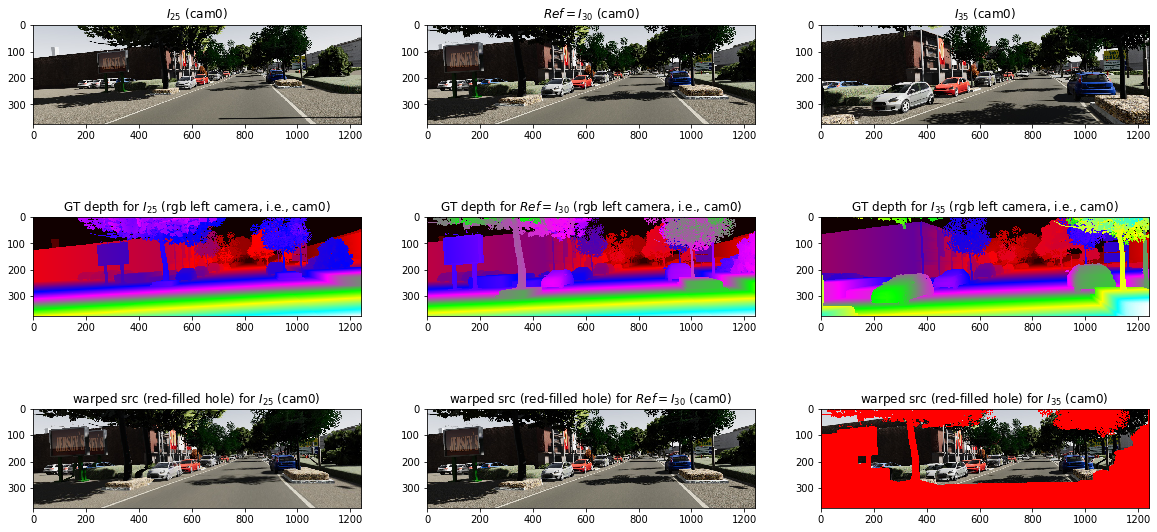

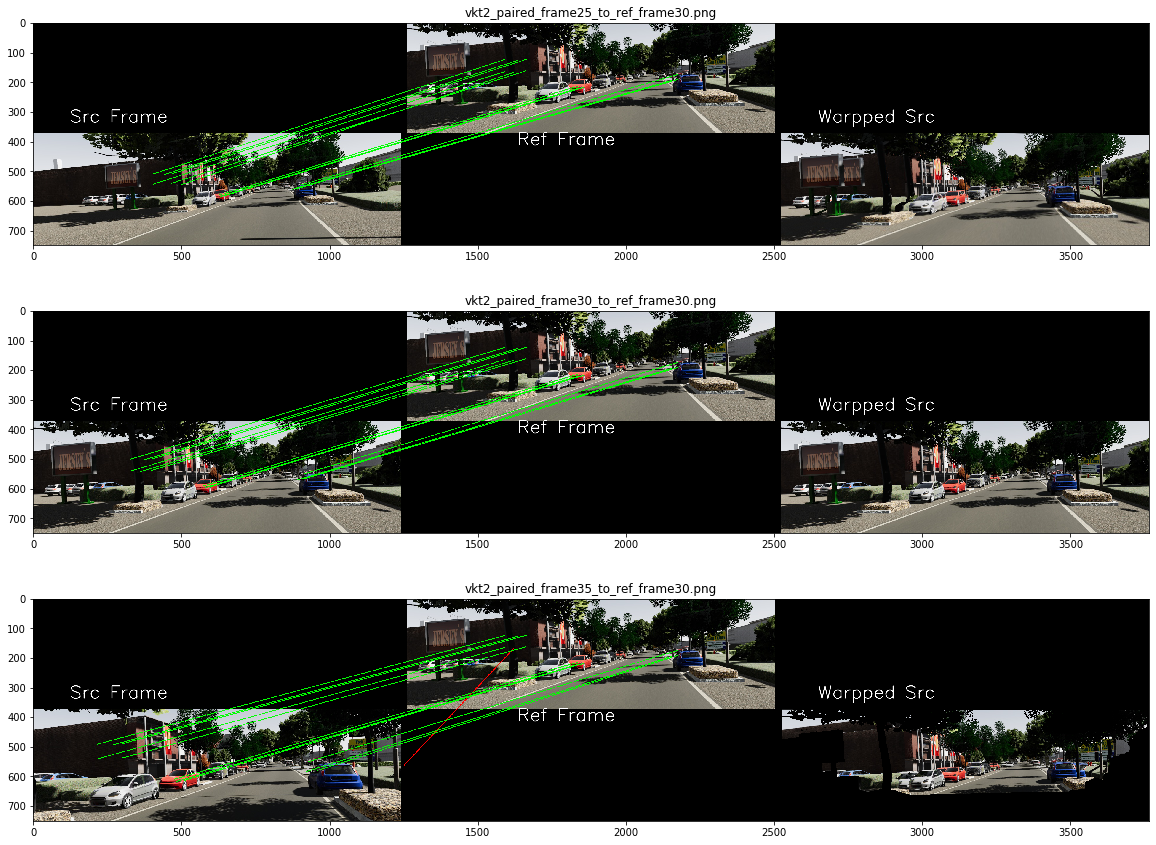

In [19]:
if __name__ == "__main__":
   ## some testing code, just IGNORE it
   import matplotlib.pyplot as plt
   import os
   import numpy as np
   import sys
   import cv2
   from os.path import join as pjoin

   from PIL import Image
   #from .loaddata import vkt2
   #from .tools.kitti_colormap import kitti_colormap
   
   # generate gt
   def _tocpu(x):
      return x.detach().cpu().numpy().copy()
   
   def getWH_idx(
      normalized_idx,  # [H, W, 2]
      width, height):
      normalized_x = normalized_idx[:,:,0]
      normalized_y = normalized_idx[:,:,1]
      x = (normalized_x +1)*(width - 1)/2 - 0.5
      y = (normalized_y + 1)*(height - 1)/2 - 0.5
      
      x = np.floor(x).astype(np.int32) + 1
      y = np.floor(y).astype(np.int32) + 1
      return np.concatenate((x[:,:,None], y[:,:,None]), axis=-1)

   
   def _fill_red_to_balck_hole(tmp_img, grid_xy):
      H = tmp_img.shape[0]
      W = tmp_img.shape[1]
      # give red color to black hole for good visualization
      for i in range(H):
         for j in range(W):
            x, y = grid_xy[i,j,:]
            if 0 <= x < W and 0 <= y < H:
               pass
            else:
               tmp_img[i,j,0] = 255
               tmp_img[i,j,1] = 0
               tmp_img[i,j,2] = 0
      return tmp_img
   
   def draw_pairlines_src_ref_warpedsrc(
      ref_img,
      src_img,
      warped_src,
      pts_xy, 
      grid_xy,
      img_name,
      line_thick = 2,
      font_scale = 0.5):
      
      H, W = ref_img.shape[0:2]
      small_edge = 20
      pairs = np.zeros((2*H, 3*W+2*small_edge, 3), dtype=np.uint8)
      pairs[H:2*H,0:W] = src_img
      pairs[0:H,W+small_edge:2*W+small_edge] = ref_img
      pairs[H:2*H,2*W+2*small_edge:3*W+2*small_edge] = warped_src
      # added some white box
      pairs[H-1:H, 2*W+2*small_edge:3*W+2*small_edge] = np.array([255,255,255])
      pairs[-1:,2*W+2*small_edge:3*W+2*small_edge] = np.array([255,255,255])
      pairs[H:2*H,2*W+2*small_edge-1:2*W+2*small_edge] = np.array([255,255,255])
      pairs[H:2*H,-1:] = np.array([255,255,255])
      
      for x,y in pts_xy:
         pts_ref = (x + W+small_edge, y)
         x_mapped, y_mapped = tmp_grid_np[y,x]
         if 0 <= x_mapped < W and 0 <= y_mapped < H:
            pts_src = (x_mapped, H + y_mapped)
            my_color=(0, 255, 0) # green for good match
         else:
            pts_src = (W+small_edge//2, H+H//2) # to region on the small_edge
            my_color=(255, 0, 0) # red for unmatchable region
         # Green color in BGR 
         cv2.line(pairs, pts_ref, pts_src, color=my_color, thickness=line_thick)
      
      cv2.putText(pairs, 'Src Frame', org = (W//10, 9*H//10), 
                  fontFace = cv2.FONT_HERSHEY_SIMPLEX,  
                  fontScale = font_scale, color = (255,255,255), 
                  thickness = line_thick, lineType = cv2.LINE_AA)  
      cv2.putText(pairs, 'Ref Frame', org = (W+W//5+small_edge+ W//10, 2*H-9*H//10), 
                  fontFace = cv2.FONT_HERSHEY_SIMPLEX,  
                  fontScale = font_scale, color = (255,255,255), 
                  thickness = line_thick, lineType = cv2.LINE_AA)  
      cv2.putText(pairs, 'Warpped Src', org = (2*W+2*small_edge + W//10, 9*H//10), 
                  fontFace = cv2.FONT_HERSHEY_SIMPLEX,  
                  fontScale = font_scale, color = (255,255,255), 
                  thickness = line_thick, lineType = cv2.LINE_AA)  
      #cv2.imwrite(img_name, pairs[:,:,::-1])    
      print("saved %s" %img_name)
      return pairs
   
   
   """ dataset: virtual kitti 2 """
   if 1: 
      # Change this to the directory where you store KITTI data
      my_base_path = "/media/ccjData2/datasets/Virtual-KITTI-V2/"
      sceneX = "Scene01"
      variantY="15-deg-left"

      # Load the data. 
      my_dataset = vkt2(my_base_path, sceneX, variantY, 
                              #frames=range(0, 20, 5)
                           )
      
      # neural rgb2d paper:
      delta_t = 5
      #delta_t = 1
      #delta_t = 2
      cur_t = 2*delta_t + 20
      #local_window = [cur_t - 2*delta_t, cur_t - delta_t, cur_t, cur_t + delta_t, cur_t + 2*delta_t]
      #names_local = [r'$I_{-2}$', r'$I_{-1}$', r'$I_{0}$', r'$I_{+1}$', r'$I_{+2}$']
      local_window = [cur_t - delta_t, cur_t, cur_t + delta_t]
      cur_t_idx = local_window.index(cur_t)
      print ("cur_t_idx = ", cur_t_idx)
      #names_local = [r'$I_{-1}$', r'$I_{0}$', r'$I_{+1}$']
      names_local = [r'$I_{%d}$'%(cur_t - delta_t), r'$Ref = I_{%d}$'%(cur_t), r'$I_{%d}$'%(cur_t+delta_t)]
      #source_frames = [my_dataset.get_cam2(idx) for idx in local_window if idx != cur_t]
      frames_local = [my_dataset.get_cam0(idx) for idx in local_window]
      ref_frame = my_dataset.get_cam0(cur_t)

      depths_local = [my_dataset.get_depth0(idx) for idx in local_window]
      ref_depth_np = my_dataset.get_depth0(cur_t)
      
      # pose, i.e., extrinsics E = [R | t]
      extM_local = [ my_dataset.get_cam0_E(idx) for idx in local_window]
      extM_ref = extM_local[cur_t_idx] # [4, 4]
      R_local_np = np.stack([E[0:3, 0:3] for E in extM_local], axis=0) #[N,3,3]
      t_local_np = np.stack([E[0:3, 3:4] for E in extM_local], axis=0) #[N,3,3]
      R_ref_cam_np = extM_ref[0:3, 0:3]
      t_ref_cam_np = extM_ref[0:3, 3:4]
      K_cam_np = my_dataset.cam0_K # [3, 3]
      
      # input data
      my_device = "cuda:0"
      src_fea_np = np.stack(frames_local, axis=0).astype(np.float32)/255.0
      print ("src_fea_np shape = ", src_fea_np.shape)
      src_fea = torch.tensor(np.transpose(src_fea_np, axes=[0, 3, 1, 2]), device=my_device)
      print ("src_fea shape = ", src_fea.shape)
      N, C, H, W = src_fea.size()
      dep_ref = torch.tensor(ref_depth_np, device=my_device)[None,None,:,:].repeat(N, 1, 1, 1) # [N,1,H,W]
      
      
      K_cam = torch.tensor(K_cam_np, device=my_device)[None,...].repeat(N,1,1) # [N, 3, 3]
      
      # ref camera (K, R, t)
      R_ref = torch.tensor(R_ref_cam_np, device=my_device)[None, ...].repeat(N, 1, 1) # [N, 3, 3]
      t_ref = torch.tensor(t_ref_cam_np, device=my_device)[None,...].repeat(N, 1, 1) # [N, 3, 1]
      
      R_src = torch.tensor(R_local_np, device=my_device) # [N, 3, 3]
      t_src = torch.tensor(t_local_np, device=my_device) # [N, 3, 1]

      warped_src_fea, grid, proj_xy = homo_warping(
         src_fea = src_fea, # [N, C, H, W]
         dep_ref = dep_ref, # [N, D, H, W], here D=Ndepth, and usually we have D=1;
         # ref camera (K, R, t)
         R_ref_cam = R_ref, # [N, 3, 3]
         t_ref_cam = t_ref, # [N, 3, 1] 
         K_ref_cam = K_cam, # [N, 3, 3]
         
         # src camera (K, R, t)
         R_src_cam = R_src, # [N, 3, 3]
         t_src_cam = t_src, # [N, 3, 1]
         K_src_cam = K_cam, # [N, 3, 3]
      )
      
      warped_src_fea_np = _tocpu(warped_src_fea) # [N, C, D, H, W]
      assert warped_src_fea_np.shape[2] == 1, "D == 1"
      warped_src_fea_np = warped_src_fea_np[:,:,0,:,:]
      warped_src_fea_np = 255*np.transpose(warped_src_fea_np, axes=[0, 2, 3, 1]) # [N, H, W, C]
      warped_src_fea_np = warped_src_fea_np.astype(np.uint8)
      
      
      grid_np = _tocpu(grid)[:,0,:,:] # [N, D=1, H, W, 2] ==> [N, H, W, 2]
      proj_xy_np = _tocpu(proj_xy)[:,0,:,:] # [N, D=1, H, W, 2] ==> [N, H, W, 2]
      
      
      f, ax = plt.subplots(3, len(local_window), figsize=(20, 10))
      for i, n in enumerate(names_local):
         ax[0, i].imshow(frames_local[i])
         ax[0, i].set_title('%s (cam0)'%n)
      
      pairs_vis = []
      for i, n in enumerate(names_local):
         print ('warped src for %s (cam0) '%n)
         print ("K for %s (cam0) : \n%s" %(n, K_cam_np))
         print ("R for %s (cam0) : \n%s" %(n, R_local_np[i]))
         print ("t for %s (cam0) : \n%s" %(n, t_local_np[i]))
         print ("E for %s (cam0) : \n%s" %(n, extM_local[i]))
         depth = depths_local[i] 
         #ax[1, i].imshow(depth, cmap='gray')
         ax[1, i].imshow( kitti_colormap(1.0/depth)) # 1/depth to mimic the kitti color for disparity map; 
         ax[1, i].set_title('GT depth for %s (rgb left camera, i.e., cam0)'%n)
         tmp_grid_np = getWH_idx(grid_np[i], width=W, height=H)
         tmp_src = warped_src_fea_np[i].copy()
         tmp_src = _fill_red_to_balck_hole(tmp_src, tmp_grid_np)
         ax[2, i].imshow(tmp_src)
         ax[2, i].set_title('warped src (red-filled hole) for %s (cam0) '%n)     
         #cv2.imwrite('./results/tmp/vkt2_warped_frame%d_to_ref_frame%d.png'%(
         #   local_window[i], cur_t), 
         #   tmp_src[:,:,::-1])
         
         src_img = np.array(frames_local[i])
         ref_img = np.array(frames_local[cur_t_idx])
         warped_src = warped_src_fea_np[i]
         vkt2_pts_xy = [
            [329,126], [375, 128], [403, 125],
            [330,166], [360, 169], [400, 164],
            [574,216], [597, 219], [579,222],
            [892,196], [913, 193], [912, 176],
            ]
         
         grid_xy = tmp_grid_np
         paired_img_name = './results/tmp/vkt2_paired_frame%d_to_ref_frame%d.png' %(
            local_window[i], cur_t)
         pairs_vis.append(draw_pairlines_src_ref_warpedsrc(
            ref_img,
            src_img,
            warped_src,
            vkt2_pts_xy, 
            grid_xy,
            paired_img_name,
            line_thick = 2,
            font_scale=2
            ))  
      
      # show mapping pairs
      print("show paired pixels between reference frame and source frame") 
      f2, ax2 = plt.subplots(len(local_window), figsize=(20, 15))
      for i in range(len(local_window)):
        ax2[i].imshow(pairs_vis[i])
        ax2[i].set_title('vkt2_paired_frame%d_to_ref_frame%d.png' %(
            local_window[i], cur_t))
      
      plt.show()

### 3.4 Testing on DTU Dataset

- See DTU Dataset Code as below

In [26]:
import os
import re
import sys
import struct
""" this file works well in Python2 & 3"""
def readPFM(file): 
    from struct import unpack
    with open(file, "rb") as f:
            # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        type = f.readline().decode('latin-1')
        if "PF" in type:
            channels = 3
        elif "Pf" in type:
            channels = 1
        else:
            sys.exit(1)
        # Line 2: width height
        line = f.readline().decode('latin-1')
        width, height = re.findall('\d+', line)
        width = int(width)
        height = int(height)

            # Line 3: +ve number means big endian, negative means little endian
        line = f.readline().decode('latin-1')
        BigEndian = True
        if "-" in line:
            BigEndian = False
        # Slurp all binary data
        samples = width * height * channels;
        buffer = f.read(samples * 4)
        # Unpack floats with appropriate endianness
        if BigEndian:
            fmt = ">"
        else:
            fmt = "<"
        fmt = fmt + str(samples) + "f"
        img = unpack(fmt, buffer)
        img = np.reshape(img, (height, width))
        img = np.flipud(img).astype(np.float32)
    return img

In [27]:
from torch.utils.data import Dataset
import numpy as np
import os
from PIL import Image
# the DTU dataset preprocessed by Yao Yao (only for training)
class MVSDataset(Dataset):
    def __init__(self, datapath, listfile, mode, nviews, ndepths=192, interval_scale=1.06, **kwargs):
        super(MVSDataset, self).__init__()
        self.datapath = datapath
        self.listfile = listfile
        self.mode = mode
        self.nviews = nviews
        self.ndepths = ndepths
        self.interval_scale = interval_scale

        assert self.mode in ["train", "val", "test"]
        self.metas = self.build_list()

    def build_list(self):
        metas = []
        with open(self.listfile) as f:
            scans = f.readlines()
            scans = [line.rstrip() for line in scans]

        # scans
        for scan in scans:
            pair_file = "Cameras/pair.txt"
            # read the pair file
            with open(os.path.join(self.datapath, pair_file)) as f:
                num_viewpoint = int(f.readline())
                # viewpoints (49)
                for view_idx in range(num_viewpoint):
                    ref_view = int(f.readline().rstrip())
                    src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
                    # light conditions 0-6
                    for light_idx in range(7):
                        metas.append((scan, light_idx, ref_view, src_views))
        print("dataset", self.mode, "metas:", len(metas))
        return metas

    def __len__(self):
        return len(self.metas)

    def read_cam_file(self, filename):
        with open(filename) as f:
            lines = f.readlines()
            lines = [line.rstrip() for line in lines]
        # extrinsics: line [1,5), 4x4 matrix
        extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ').reshape((4, 4))
        # intrinsics: line [7-10), 3x3 matrix
        intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ').reshape((3, 3))
        # depth_min & depth_interval: line 11
        depth_min = float(lines[11].split()[0])
        depth_interval = float(lines[11].split()[1]) * self.interval_scale
        return intrinsics, extrinsics, depth_min, depth_interval

    def read_img(self, filename):
        img = Image.open(filename)
        # scale 0~255 to 0~1
        np_img = np.array(img, dtype=np.float32) / 255.
        return np_img

    def read_depth(self, filename):
        # read pfm depth file
        return readPFM(filename)

    def __getitem__(self, idx):
        meta = self.metas[idx]
        scan, light_idx, ref_view, src_views = meta
        # use only the reference view and first nviews-1 source views
        view_ids = [ref_view] + src_views[:self.nviews - 1]

        imgs = []
        mask = None
        depth = None
        depth_values = None
        proj_matrices = []
        intrinsic_matrices = []
        extrinsic_matrices = []

        for i, vid in enumerate(view_ids):
            # NOTE that the id in image file names is from 1 to 49 (not 0~48)
            img_filename = os.path.join(self.datapath,
                                        'Rectified/{}_train/rect_{:0>3}_{}_r5000.png'.format(scan, vid + 1, light_idx))
            mask_filename = os.path.join(self.datapath, 'Depths/{}_train/depth_visual_{:0>4}.png'.format(scan, vid))
            depth_filename = os.path.join(self.datapath, 'Depths/{}_train/depth_map_{:0>4}.pfm'.format(scan, vid))
            proj_mat_filename = os.path.join(self.datapath, 'Cameras/train/{:0>8}_cam.txt').format(vid)

            imgs.append(self.read_img(img_filename))
            intrinsics, extrinsics, depth_min, depth_interval = self.read_cam_file(proj_mat_filename)
            
            intrinsic_matrices.append(intrinsics.copy())
            extrinsic_matrices.append(extrinsics.copy())

            # multiply intrinsics and extrinsics to get projection matrix
            proj_mat = extrinsics.copy()
            proj_mat[:3, :4] = np.matmul(intrinsics, proj_mat[:3, :4])
            proj_matrices.append(proj_mat)

            if i == 0:  # reference view
                depth_values = np.arange(depth_min, depth_interval * self.ndepths + depth_min, depth_interval,
                                         dtype=np.float32)
                mask = self.read_img(mask_filename)
                depth = self.read_depth(depth_filename)

        imgs = np.stack(imgs).transpose([0, 3, 1, 2])
        proj_matrices = np.stack(proj_matrices)
        intrinsic_matrices = np.stack(intrinsic_matrices)
        extrinsic_matrices = np.stack(extrinsic_matrices)

        return {"imgs": imgs,
                "proj_matrices": proj_matrices,
                "intrinsics": intrinsic_matrices,
                "extrinsics": extrinsic_matrices,
                "depth": depth,
                "depth_values": depth_values,
                "mask": mask,
                "view_ids": np.array(view_ids, dtype=int)
                }

dataset train metas: 27097
dict_keys(['imgs', 'proj_matrices', 'intrinsics', 'extrinsics', 'depth', 'depth_values', 'mask', 'view_ids'])
imgs: (3, 3, 512, 640)
proj_matrices: (3, 4, 4)
intrinsics: (3, 3, 3)
extrinsics: (3, 4, 4)
depth: (128, 160)
depth_values: (128,)
mask: (128, 160)
view_ids: (3,)
src_fea_np shape =  (3, 3, 128, 160)
src_fea shape =  torch.Size([3, 3, 128, 160])
dep_ref shape =  torch.Size([3, 1, 128, 160])
ref E = 
[[ 6.04034e-02 -8.72690e-01  4.84524e-01 -3.15961e+02]
 [ 7.40743e-01  3.64556e-01  5.64268e-01 -3.71996e+02]
 [-6.69067e-01  3.24824e-01  6.68460e-01  2.33091e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]]
ref R = 
[[ 0.0604034 -0.87269    0.484524 ]
 [ 0.740743   0.364556   0.564268 ]
 [-0.669067   0.324824   0.66846  ]]
ref t = 
[[-315.961]
 [-371.996]
 [ 233.091]]
ref K = 
[[361.54126   0.       82.90075]
 [  0.      360.3975   66.38362]
 [  0.        0.        1.     ]]
R_src shape =  torch.Size([3, 3, 3])
t_src shape =  torch.Size([3, 3

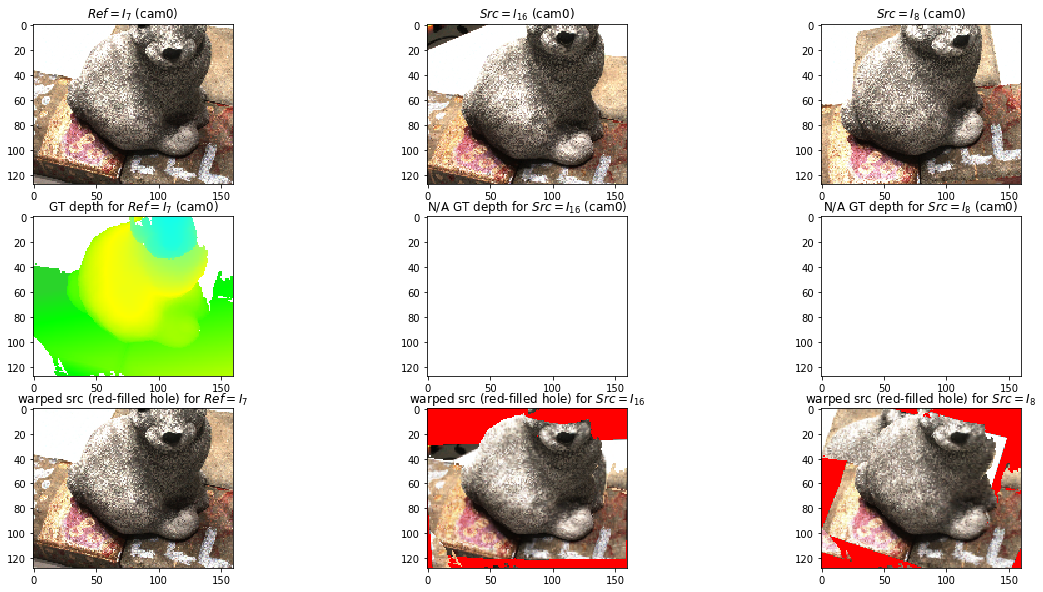

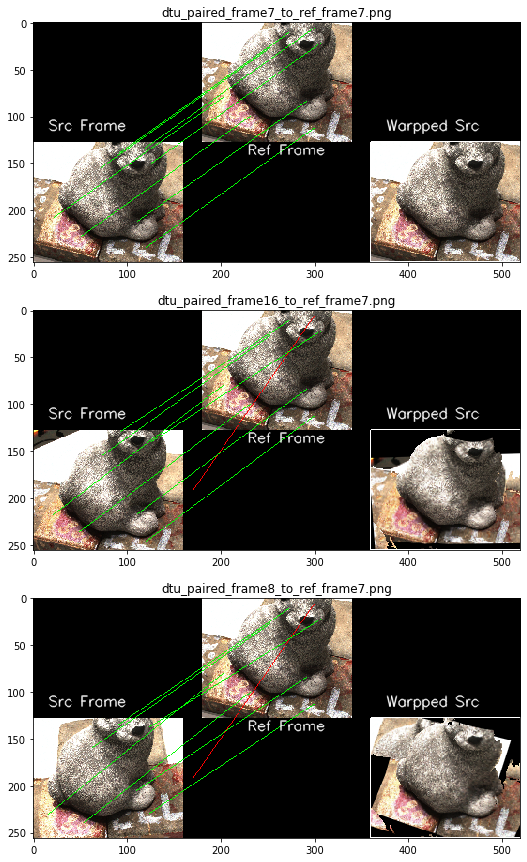

In [28]:
if __name__ == "__main__":
   ## some testing code, just IGNORE it   
   
   """ dataset: DTU """
   #from .loaddata.dtu_yao import MVSDataset
   if 1: 
      modes = ['train', 'val', 'test']
      my_mode = modes[0]
      nviews = 3
      dataset = MVSDataset("/media/ccjData3_HDD/datasets/mvs_data/dtu_mvs", 
                           '/home/ccj/mvs-depth/lists/dtu/%s.txt'%(my_mode), 
                           mode = my_mode,
                           nviews = nviews, 
                           #ndepths= 192
                           ndepths= 128
                           )
      item = dataset[50]

      # test homography here
      print(item.keys())
      for k in item:
         print ("%s: %s" %(k, item[k].shape))

      #print("imgs", item["imgs"].shape)
      #print("depth", item["depth"].shape)
      #print("depth_values", item["depth_values"].shape)
      #print("mask", item["mask"].shape)
      #sys.exit()
      
      
      
      # input data
      frames_local = item["imgs"][:,:, ::4, ::4] # 1/4 downsample
      ref_depth_np = item["depth"]
      depth_values = item["depth_values"]
      DEPTH_MIN = depth_values[0]
      DEPTH_MAX = depth_values[-1]
      ref_depth_np[ref_depth_np < DEPTH_MIN] = DEPTH_MIN
      ref_depth_np[ref_depth_np > DEPTH_MAX] = DEPTH_MAX
      depth_mask = item["mask"]
      local_window = item["view_ids"]
      names_local = []
      for i, id in enumerate(local_window):
         if i == 0: # reference view
            names_local.append(r'$Ref = I_{%d}$'%(id))
         else:
            names_local.append(r'$Src = I_{%d}$'%(id))

      my_device = "cuda:0"
      #src_fea_np = frames_local.astype(np.float32)/255.0
      src_fea_np = frames_local.astype(np.float32) # already in [0,1] range;
      print ("src_fea_np shape = ", src_fea_np.shape)
      src_fea = torch.tensor(src_fea_np, device=my_device)
      print ("src_fea shape = ", src_fea.shape)
      N, C, H, W = src_fea.size()
      dep_ref = torch.tensor(ref_depth_np, device=my_device)[None,None,:,:].repeat(N, 1, 1, 1) # [N,1,H,W]
      print ("dep_ref shape = ", dep_ref.shape)
      
      # pose, i.e., extrinsics E = [R | t]
      ref_idx = 0
      cur_t = local_window[ref_idx]
      extM_local = item['extrinsics']
      K_local = item['intrinsics']

      R_local_np = extM_local[:,0:3,0:3] #[N,3,3]
      t_local_np = extM_local[:,0:3,3:4] #[N,3,1]
      extM_ref = extM_local[ref_idx] # [4, 4]
      print ("ref E = \n%s" %(extM_ref))
      R_ref_cam_np = extM_ref[0:3, 0:3]
      t_ref_cam_np = extM_ref[0:3, 3:4]
      K_ref_cam_np = K_local[ref_idx]
      print ("ref R = \n%s" %(R_ref_cam_np))
      print ("ref t = \n%s" %(t_ref_cam_np))
      print ("ref K = \n%s" %(K_ref_cam_np))
      
      
      # ref camera (K, R, t)
      R_ref = torch.tensor(R_ref_cam_np, device=my_device)[None, ...].repeat(N, 1, 1) # [N, 3, 3]
      t_ref = torch.tensor(t_ref_cam_np, device=my_device)[None,...].repeat(N, 1, 1) # [N, 3, 1]
      K_ref = torch.tensor(K_ref_cam_np, device=my_device)[None,...].repeat(N,1,1) # [N, 3, 3]
      
      R_src = torch.tensor(R_local_np, device=my_device) # [N, 3, 3]
      t_src = torch.tensor(t_local_np, device=my_device) # [N, 3, 1]
      K_src = torch.tensor(K_local, device=my_device) # [N, 3, 3]
      print ("R_src shape = ", R_src.shape)
      print ("t_src shape = ", t_src.shape)
      print ("K_src shape = ", K_src.shape)

      warped_src_fea, grid, proj_xy = homo_warping(
         src_fea = src_fea, # [N, C, H, W]
         dep_ref = dep_ref, # [N, D, H, W], here D=Ndepth, and usually we have D=1;
         # ref camera (K, R, t)
         R_ref_cam = R_ref, # [N, 3, 3]
         t_ref_cam = t_ref, # [N, 3, 1] 
         K_ref_cam = K_ref, # [N, 3, 3]
         
         # src camera (K, R, t)
         R_src_cam = R_src, # [N, 3, 3]
         t_src_cam = t_src, # [N, 3, 1]
         K_src_cam = K_src, # [N, 3, 3]
      )
      
      warped_src_fea_np = _tocpu(warped_src_fea) # [N, C, D, H, W]
      assert warped_src_fea_np.shape[2] == 1, "D == 1"
      warped_src_fea_np = warped_src_fea_np[:,:,0,:,:]
      warped_src_fea_np = 255*np.transpose(warped_src_fea_np, axes=[0, 2, 3, 1]) # [N, H, W, C]
      warped_src_fea_np = warped_src_fea_np.astype(np.uint8)

      # check grid 
      grid_np = _tocpu(grid)[:,0,:,:] # [N, D=1, H, W, 2] ==> [N, H, W, 2]
      proj_xy_np = _tocpu(proj_xy)[:,0,:,:] # [N, D=1, H, W, 2] ==> [N, H, W, 2]

      
      f, ax = plt.subplots(3, len(local_window), figsize=(20, 10))
      # > see: https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib 
      # You can use plt.subplots_adjust to change the spacing between the subplots;
      if 0:
         #f.tight_layout() # Or equivalently,  "plt.tight_layout()"
         left  = 0.125  # the left side of the subplots of the figure
         right = 0.9    # the right side of the subplots of the figure
         bottom = 0.1   # the bottom of the subplots of the figure
         top = 0.9      # the top of the subplots of the figure
         wspace = 0.2   # the amount of width reserved for blank space between subplots
         hspace = 0.2   # the amount of height reserved for white space between subplots
         plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
      for i, n in enumerate(names_local):
         ax[0, i].imshow(frames_local[i].transpose([1, 2, 0]) )
         ax[0, i].set_title('%s (cam0)'%n)
      pairs_vis = []
      for i, n in enumerate(names_local):
         if i == ref_idx:
            depth = ref_depth_np 
            depth[depth < 1e-3] = 1e-3
            ax[1, i].set_title('GT depth for %s (cam0)'%n)
         else:
            depth = np.zeros(ref_depth_np.shape) + 1e-3
            ax[1, i].set_title('N/A GT depth for %s (cam0)'%n)
         #ax[1, i].imshow(depth, cmap='gray')
         ax[1, i].imshow( kitti_colormap(1.0/depth)) # 1/depth to mimic the kitti color for disparity map; 
         #ax[1, i].set_title('GT depth for %s (rgb left camera, i.e., cam0)'%n)

         tmp_grid_np = getWH_idx(grid_np[i], width=W, height=H)
         tmp_src = warped_src_fea_np[i].copy()
         tmp_src = _fill_red_to_balck_hole(tmp_src, tmp_grid_np)


         ax[2, i].imshow(tmp_src)
         ax[2, i].set_title('warped src (red-filled hole) for %s'%n)     
         cv2.imwrite('./results/tmp/dtu_warped_frame%d_to_ref_frame%d.png'%(
            local_window[i], cur_t), 
            tmp_src[:,:,::-1])
         
         src_img = frames_local[i].transpose([1, 2, 0])*255
         src_img = src_img.astype(np.uint8)
         ref_img = frames_local[ref_idx].transpose([1, 2, 0])*255
         ref_img = ref_img.astype(np.uint8)
         warped_src = warped_src_fea_np[i]
         dtu_pts_xy = [
            [92,11], [119, 6], [126, 22],
            [72,27], [111, 84], [22, 80],
            [51, 100], [120, 112],
            ]
         grid_xy = tmp_grid_np
         paired_img_name = './results/tmp/dtu_paired_frame%d_to_ref_frame%d.png' %(
            local_window[i], cur_t)
         pairs_vis.append(draw_pairlines_src_ref_warpedsrc(
            ref_img,
            src_img,
            warped_src,
            dtu_pts_xy, 
            grid_xy,
            paired_img_name,
            line_thick = 1
            ))
      # show mapping pairs
      print("show paired pixels between reference frame and source frame") 
      f2, ax2 = plt.subplots(len(local_window), figsize=(20, 15))
      for i in range(len(local_window)):
        ax2[i].imshow(pairs_vis[i])
        ax2[i].set_title('dtu_paired_frame%d_to_ref_frame%d.png' %(
            local_window[i], cur_t))
      #plt.show()